In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')

In [ ]:
!pip3 install transformers
!cp /content/drive/MyDrive/fake-news-explainability/utils_fake_news.py .
!git clone https://github.com/fhvilshoj/TorchLRP.git

In [3]:
!cp TorchLRP/examples/utils.py .
!cp TorchLRP/examples/visualization.py .

In [ ]:
import pandas as pd
import numpy as np
import json, re, os
from tqdm import tqdm_notebook
from uuid import uuid4
import time
import datetime
import random
import itertools
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
sys.path.insert(1, '/content/TorchLRP')


## Torch Modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import (
    Dataset, 
    DataLoader,
    TensorDataset, 
    random_split, 
    RandomSampler, 
    SequentialSampler)

# Transformers
from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    AdamW,
    get_linear_schedule_with_warmup)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# LRP
import lrp
from utils import get_mnist_model, prepare_mnist_model, get_mnist_data
from utils import store_patterns, load_patterns
from visualization import heatmap_grid
from lrp.patterns import fit_patternnet, fit_patternnet_positive

# Encoding and Utils
%run utils_fake_news.py

# Device
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu")

## Data Preprocessing

In [5]:
# Load the Fake-News Kaggle dataset
df_train = pd.read_csv("/content/drive/MyDrive/fake-news-explainability/Data/Raw/fake_news.csv")
df_train = df_train.dropna(subset=['statement'])

# Encode dataframes using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_train['statement'])
vocab = vectorizer.get_feature_names()

# Convert to sparse PyTorch matrix
X = X.tocoo()
X = torch.sparse.FloatTensor(torch.LongTensor([X.row.tolist(), X.col.tolist()]),
                             torch.FloatTensor(X.data.astype(np.float)))

# Feed as TensorDataset
df_encode = TensorDataset(X, torch.LongTensor(df_train['label']))

## Model & Training Function

In [6]:
import torch.nn as nn
from transformers import AutoModel

def train():
    total_t0 = time.time()
    for epoch_i in range(0, epochs):
        
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        t0 = time.time()
        total_train_loss = 0
        bert_model.train()

        for step, batch in enumerate(bert_train_dataloader):
            # Unpack batch
            b_input = batch[0].to(device)
            b_labels = batch[1].to(device)

            # Zero grads
            bert_model.zero_grad()        

            # Forward pass
            output = bert_model(b_input)
            
            # Accumulate loss
            loss = loss_func(output.squeeze(1), b_labels)
            
            # Backpropagate
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            # torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The bert_optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            bert_optimizer.step()

            # Update the learning rate.
            bert_scheduler.step()

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(bert_train_dataloader), elapsed))
                print(f'Loss: {loss.detach()}')
                
        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(bert_train_dataloader)            
        
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(training_time))

        # Record all statistics from this epoch.
        bert_training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                # 'Valid. Loss': avg_val_loss,
                # 'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                # 'Validation Time': validation_time
            }
        )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

## Load Data

In [7]:
# Load data into dataloader
batch_size = 32
bert_train_dataloader = DataLoader(
    df_encode,  # The training samples.
    batch_size = batch_size # Trains with this batch size.
    )

## Training

In [8]:
# Model
vocab_size = X.shape[1]
bert_model = lrp.Sequential(
                     lrp.Linear(vocab_size, 153),
                     torch.nn.ReLU(),
                     lrp.Linear(153,32),
                     torch.nn.ReLU(),
                     lrp.Linear(32,2)
                 ).to(device)

# Optimizer
bert_optimizer = AdamW(bert_model.parameters(),
                  lr = 5e-3, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Training Params
bert_training_stats = []
epochs = 2
total_steps = len(bert_train_dataloader) * epochs
loss_func = nn.CrossEntropyLoss()

# Learning rate scheduler.
bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer, 
                                                 num_warmup_steps = 0, # Default value in run_glue.py
                                                 num_training_steps = total_steps)

In [9]:
# Train or load pre-trained
tfidf_model = "/content/drive/MyDrive/fake-news-explainability/Models/fake_news_model_tfidf"

if os.path.exists(tfidf_model):
    bert_model.load_state_dict(torch.load(tfidf_model, map_location=device))
else:
    train()
    torch.save(bert_model.state_dict(), tfidf_model)

## Evaluate (On Fake-News Train Set)

In [10]:
with torch.no_grad():
    outputs = bert_model.forward(X.to(device))
    print(f"Acc: {flat_accuracy(outputs.detach().cpu().numpy(), df_encode.tensors[1].to('cpu').numpy())}")

Acc: 0.9950597767019069


In [ ]:
all_patterns_path = '/content/drive/MyDrive/fake-news-explainability/TorchLRP-master/examples/patterns/pattern_all.pkl'
if not os.path.exists(all_patterns_path):
    patterns_all = fit_patternnet(bert_model, bert_train_dataloader, device=device)
    store_patterns(all_patterns_path, patterns_all)
    !cp TorchLRP/examples/patterns/pattern_all.pkl drive/MyDrive/fake-news-explainability/TorchLRP-master/examples/patterns
else:
    patterns_all = [torch.tensor(p, device=device, dtype=torch.float32) for p in load_patterns(all_patterns_path)]

## LRP Explanations

In [ ]:
def generate_explanations(lst):
    # Vectorize the input
    X = vectorizer.transform(lst).todense()

    # To PyTorch
    X = torch.Tensor(X)

    # Format sample data from positive class
    X = X.requires_grad_(True)
    X.grad = None

    # Make prediction
    y_hat = bert_model.forward(X.to(device), explain=True, rule="alpha2beta1")
    preds = y_hat
    y_hat = y_hat[range(X.shape[0]), y_hat.max(1)[1]] # Choose maximizing output neuron
    y_hat = y_hat.sum()

    # Backward pass (do explanation)
    y_hat.backward()
    explanation = X.grad
    
    return explanation, preds

# Get the vocab with the top 10 highest explanation scores (by magnitude)
def top_k_explanations(explanation, k, vocab=vocab, manual_keys=[]):
    
    n_obs = explanation.shape[0]
    
    # Collect top k indices
    explanation_idx = torch.topk(torch.abs(explanation), k=k, dim=1).indices
    
    # Manually add any selected words' indices
    for word in manual_keys:
        if word in vocab:
            explanation_idx = torch.hstack((explanation_idx,
                                            torch.tensor([vocab.index(word)])\
                                                 .repeat(n_obs,1)))
        else:
            print(f"'{word}' not in vocab")
    
    # Get their magnitudes
    explanation_val = torch.vstack([explanation[i][explanation_idx[i]] for i in range(n_obs)])
    
    # Get corresponding vocab
    explanation_key = [[vocab[idx] for idx in explanation_idx[i]] for i in range(n_obs)]
    return explanation_val, explanation_key

def as_pyplot_figure(vals, names, title=''):
    """Returns the explanation as a pyplot figure.
    Will throw an error if you don't have matplotlib installed
    Args:
        label: desired label. If you ask for a label for which an
                explanation wasn't computed, will throw an exception.
                Will be ignored for regression explanations.
        kwargs: keyword arguments, passed to domain_mapper
    Returns:
        pyplot figure (barchart).
    """
    import matplotlib.pyplot as plt
    vals, names = vals[::-1], names[::-1]
    fig = plt.figure()
    colors = ['orange' if x > 0 else 'blue' for x in vals]
    pos = np.arange(len(vals)) + .5
    plt.barh(pos, vals, align='center', color=colors)
    plt.yticks(pos, names)
    main_title = title if title else 'Local Explanation'
    plt.title(main_title)

## Negation

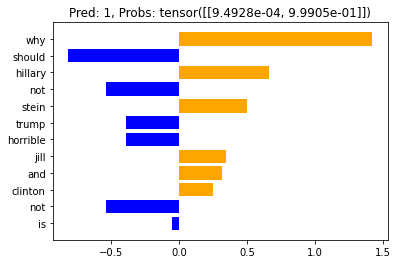

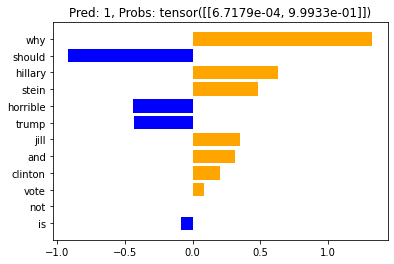

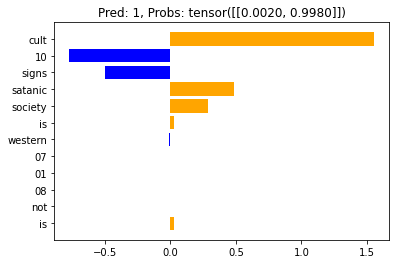

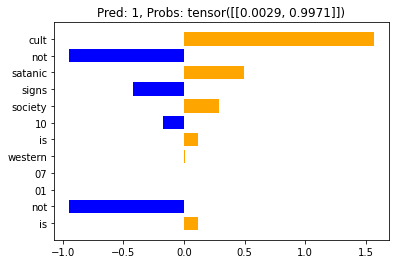

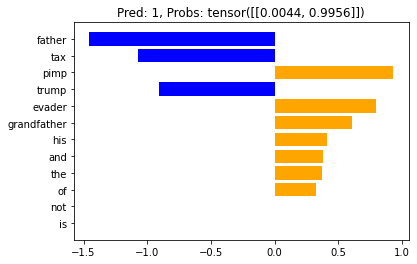

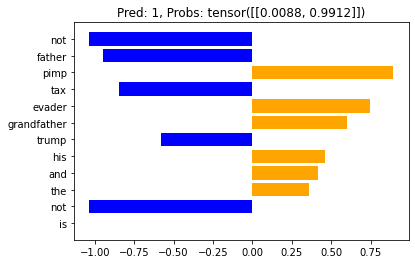

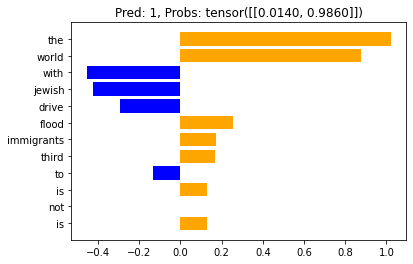

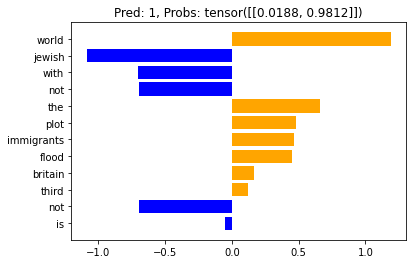

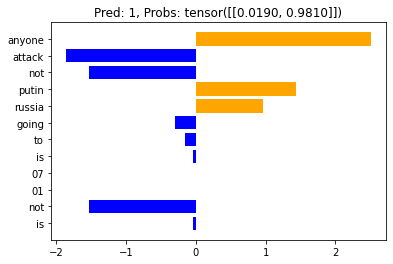

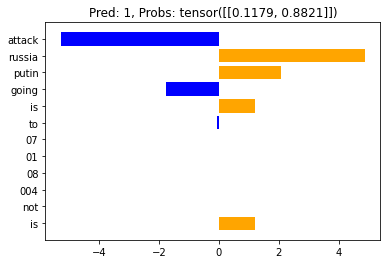

In [ ]:
orig_lst = ['Why Donald Trump is not as horrible as Hillary Clinton " and why you should vote for Jill Stein.',
            '10 Signs Western Society is a Satanic Cult',
            'Trump’s grandfather was a pimp and tax evader; his father a member of the KKK',
            'The Drive to Flood Britain with Third World Immigrants is a Jewish Plot',
            'Putin: Russia is not going to attack anyone']
negd_lst = ['Why Donald Trump is as horrible as Hillary Clinton " and why you should vote for Jill Stein.',
            '10 Signs Western Society is not a Satanic Cult',
            'Trump’s grandfather was not a pimp and tax evader; his father not a member of the KKK',
            'The Drive to Flood Britain with Third World Immigrants is not a Jewish Plot',
            'Putin: Russia is going to attack']

# Generate explanations
explanation_pos, pred_pos = generate_explanations(orig_lst)
explanation_neg, pred_neg = generate_explanations(negd_lst)

# Get the vocab with the top 10 highest explanation scores (by magnitude)
vals_pos, names_pos = top_k_explanations(explanation_pos, k=10, manual_keys=['not','is'])
vals_neg, names_neg = top_k_explanations(explanation_neg, k=10, manual_keys=['not','is'])

# Show the explanation
softmax = nn.Softmax(dim=1)

for i in range(len(vals_pos)):
    ppos = pred_pos[i].detach().cpu()
    pneg = pred_neg[i].detach().cpu()
    as_pyplot_figure(vals = vals_pos[i].tolist(), 
                     names = names_pos[i], 
                     title = f"Pred: {int(torch.argmax(ppos))}, Probs: {softmax(ppos.unsqueeze(0))}")
    as_pyplot_figure(vals = vals_neg[i].tolist(), 
                     names = names_neg[i],
                     title = f"Pred: {int(torch.argmax(pneg))}, Probs: {softmax(pneg.unsqueeze(0))}")

## Name Changing

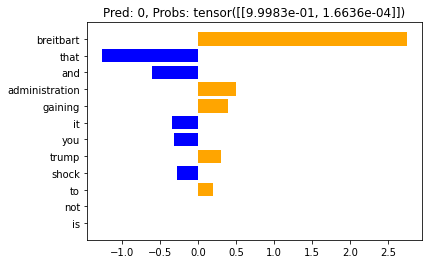

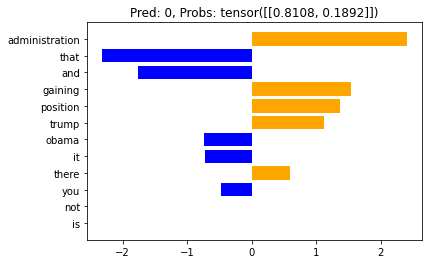

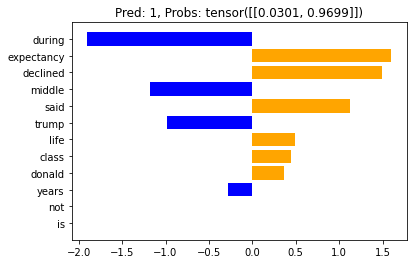

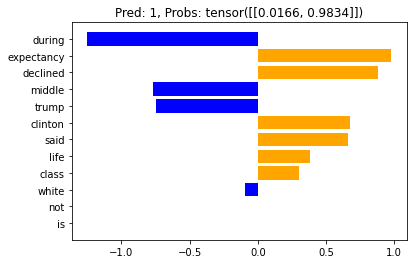

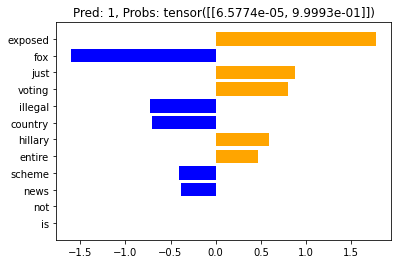

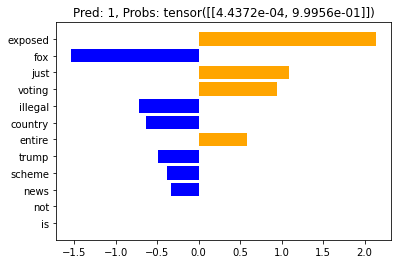

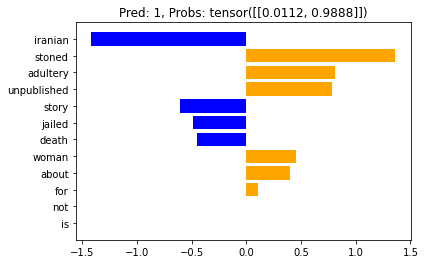

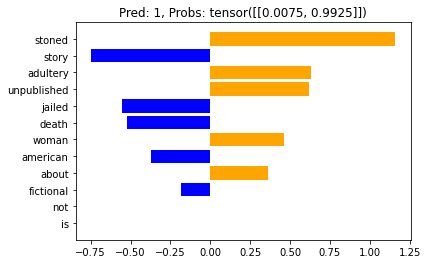

In [ ]:
# Transform sentence
orig_lst = ['There’s Only One Trump Administration Position That’s Gaining Popularity And It’s Going To Shock You - Breitbart',
            'Donald Trump Said White Middle-class Life Expectancy Declined During Obama Years',
            'Fox News Just Exposed Hillary’s ILLEGAL VOTING Scheme To The Entire Country!',
            'Iranian woman jailed for fictional unpublished story about woman stoned to death for adultery']
negd_lst = ['There’s Only One Trump Administration Position That’s Gaining Popularity And It’s Going To Shock You - Obama',
            'Donald Trump Said White Middle-class Life Expectancy Declined During Clinton Years',
            'Fox News Just Exposed Trump ILLEGAL VOTING Scheme To The Entire Country!',
            'American woman jailed for fictional unpublished story about woman stoned to death for adultery']

# Generate explanations
explanation_pos, pred_pos = generate_explanations(orig_lst)
explanation_neg, pred_neg = generate_explanations(negd_lst)

# Get the vocab with the top 10 highest explanation scores (by magnitude)
vals_pos, names_pos = top_k_explanations(explanation_pos, k=10, manual_keys=['not','is'])
vals_neg, names_neg = top_k_explanations(explanation_neg, k=10, manual_keys=['not','is'])

# Show the explanation
softmax = nn.Softmax(dim=1)

for i in range(len(vals_pos)):
    ppos = pred_pos[i].detach().cpu()
    pneg = pred_neg[i].detach().cpu()
    as_pyplot_figure(vals = vals_pos[i].tolist(), 
                     names = names_pos[i], 
                     title = f"Pred: {int(torch.argmax(ppos))}, Probs: {softmax(ppos.unsqueeze(0))}")
    as_pyplot_figure(vals = vals_neg[i].tolist(), 
                     names = names_neg[i],
                     title = f"Pred: {int(torch.argmax(pneg))}, Probs: {softmax(pneg.unsqueeze(0))}")
    